# Построение модели определения стоимости автомобиля

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**
Данные находятся в файле /datasets/autos.csv.

Признаки

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    NotRepaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя

Целевой признак

    Price — цена (евро)

In [129]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

## Подготовка данных

In [130]:
# загрузка данных
try:
    cars = pd.read_csv('autos.csv') # Локальный путь
except:
    cars = pd.read_csv('/datasets/autos.csv') # Сервесный путь 

In [131]:
cars.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [132]:
cars.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [133]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [134]:
cars.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Из обзора данных видим, что данные требуют предобработки:
 - есть NaN в
 
       VehicleType
       Gearbox
       Model
       FuelType
       NotRepaired - заменим на unknown
       
 - Колонки LastSeen  DateCrawled  и DateCreated необходимо привести к типу DateTime

 - есть выбросы в 

       Price - нулевая цена и слишком высокая цена (но это может быть машина бизнесс класса)
       Power - нулевая мощьность и слишком большая мощность (одниковая с ценой, скорее всего ошибка)
       RegistrationYear - минимальные и максимальные значения 1000 и 9999, соответсвенно
       RegistrationMonth - нулевой месяц
    
Рассмотрим все подробнее

### Колонки с датами

In [135]:
# Приведем колонки с датами к типу DateTime

cars['DateCrawled'] = pd.to_datetime(cars['DateCrawled'],format = '%Y-%m-%d %H:%M:%S')
cars['DateCreated'] = pd.to_datetime(cars['DateCreated'],format = '%Y-%m-%d %H:%M:%S')
cars['LastSeen'] = pd.to_datetime(cars['LastSeen'],format = '%Y-%m-%d %H:%M:%S')

cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

### 'Price'

In [136]:
def box_hist_plot(data,column_name):
    
    bins=100
    fig_size = (10,5)
    
    plt.subplot(2,1,1)
    data[column_name].hist(bins=bins, 
                           figsize=fig_size 
                          )

    plt.subplot(2,1,2)
    data.boxplot(column=column_name,
                 vert=False,
                 figsize=fig_size 
                )
    plt.show()

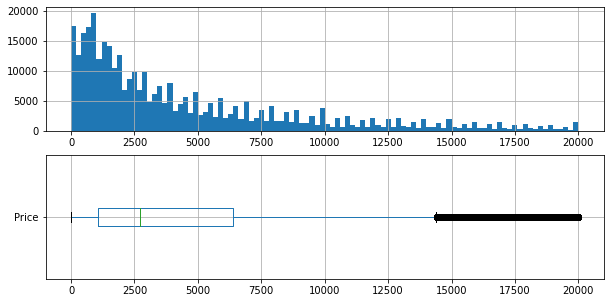

In [137]:
box_hist_plot(cars,'Price')

Строки с нулевой ценой не подходят для данного исследования, поэтому удалим их.

In [138]:
cars_cut = cars.query("Price > 0")

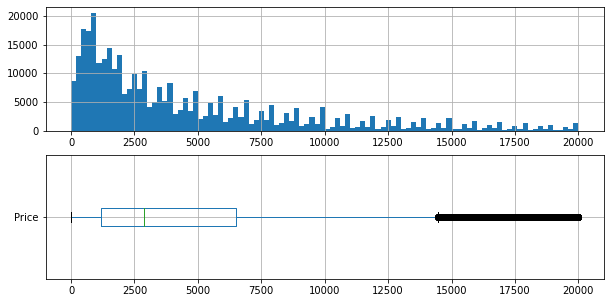

In [139]:
box_hist_plot(cars_cut,'Price')

### 'RegistrationYear'

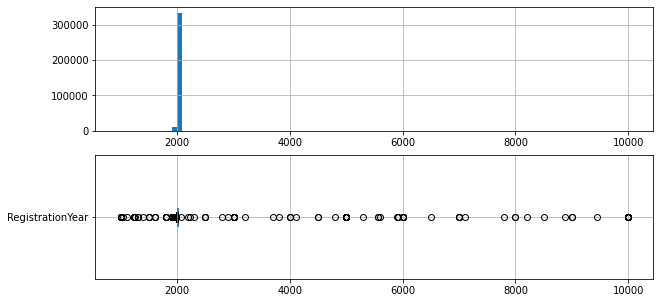

In [140]:
box_hist_plot(cars_cut,'RegistrationYear')

In [141]:
cars_cut['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1234, 1255, 1300, 1400, 1500, 1600, 1602,
       1800, 1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222,
       2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500,
       4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100,
       7800, 8000, 8200, 8500, 8888, 9000, 9450, 9999])

Значения года до 1910 и после 2019 не имеют смысла и являются ошибками. 
Так как имеющийся объем данных большой -- около 350 тыс. -- удалим строки с явными ошибками.

In [142]:
cars_cut = cars_cut.query("1910 <= RegistrationYear <= 2019")

In [143]:
pd.DatetimeIndex(cars_cut['DateCrawled']).year.unique()

Int64Index([2016], dtype='int64', name='DateCrawled')

В колонке 'DateCrawled' год везде одинаковый. Данная колока не инфомативна для предсказаний

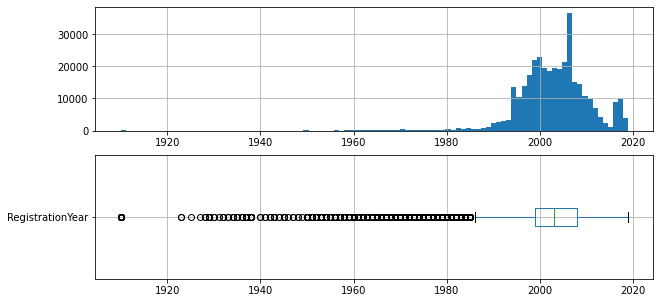

In [144]:
box_hist_plot(cars_cut,'RegistrationYear')

До 1980 года количесво машин небольшое. Для работы оставим только машины с 1980 года.

In [145]:
cars_cut = cars_cut.query("1980 <= RegistrationYear <= 2019")

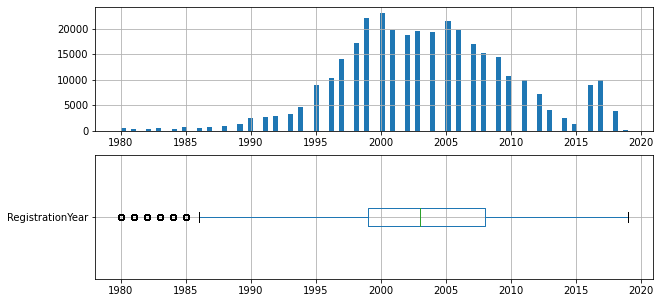

In [146]:
box_hist_plot(cars_cut,'RegistrationYear')

### Power

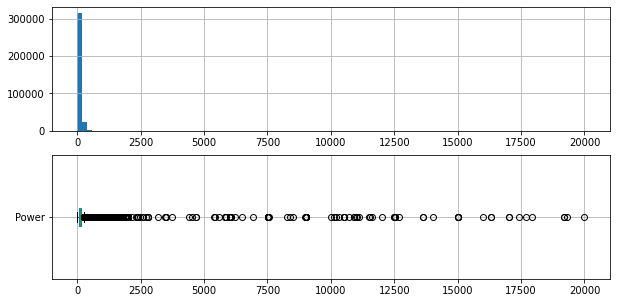

In [147]:
box_hist_plot(cars_cut,'Power')

Удалим строки с явными ошибками -- даже у гоночных машин количесво лошадиных сил около 500.
Удалим строки с нулевой мощностью и мощьностью выше 250.

In [148]:
cars_cut = cars_cut.query("0 < Power <= 250")

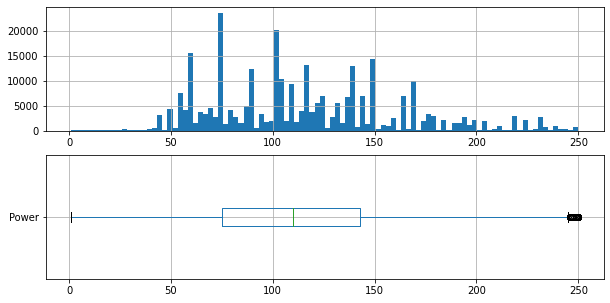

In [149]:
box_hist_plot(cars_cut,'Power')

### NotRepaired

In [150]:
cars_cut['NotRepaired'].unique()

array(['yes', nan, 'no'], dtype=object)

Значения NaN в колонке 'NotRepaired' может означать как то, что машина не ремонтировалась, так и то, что факт ремонта хотят скрыть.
Поэтому заменим NaN на 'unknown'.

In [151]:
cars_cut['NotRepaired'] = cars_cut['NotRepaired'].fillna('unknown')

### 'Model'

Удалим строки где неизвестна модель, так как неизвестная модель вносить слишком большой разброс цену.

In [152]:
cars_cut = cars_cut.dropna(subset=['Model'])

### FuelType

In [153]:
cars_cut['FuelType'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

'gasoline' и 'petrol' - это одно и тоже, поэтому приведем к одному названию.

In [154]:
cars_cut['FuelType'] = cars_cut['FuelType'].replace('petrol','gasoline')

In [155]:
cars_cut['FuelType'].value_counts()

gasoline    265460
lpg           4066
cng            482
hybrid         182
other           65
electric        58
Name: FuelType, dtype: int64

Подавляющее большинство машин работают на бензине. Поэтому заменим NaN на 'gasoline'. Большой ошибки в обучение это не внесет.

In [156]:
cars_cut['FuelType'] = cars_cut['FuelType'].fillna('gasoline')

In [157]:
cars_cut['FuelType'].value_counts()

gasoline    281482
lpg           4066
cng            482
hybrid         182
other           65
electric        58
Name: FuelType, dtype: int64

### 'VehicleType',  'Gearbox'

In [158]:
cars_cut['VehicleType'].value_counts()

sedan          77165
small          67457
wagon          56616
bus            25395
convertible    17338
coupe          12446
suv             9577
other           2117
Name: VehicleType, dtype: int64

In [159]:
cars_cut['Gearbox'].value_counts()

manual    228473
auto       52718
Name: Gearbox, dtype: int64

Для колонок 'VehicleType',  'Gearbox' заполнение наиболее часто встречающимися значениями будет вносить большую ошибку. Для 'VehicleType' частотность примерно одинаковая для топ 3 типов, а в случае коробки передач она может быть разной для одной и той же модели машины и сильно влиять на стоимость. Поэтому заменим NaN на 'unspecified'.

In [160]:
cars_cut['Gearbox'] = cars_cut['Gearbox'].fillna( 'unspecified')
cars_cut['VehicleType'] = cars_cut['VehicleType'].fillna( 'unspecified')

### Дубликаты

Неявные дубликаты были исправлены, теперь посмотрим на явные дубликаты

In [161]:
print('Количесво явных дубликатов:',cars_cut.duplicated().sum())

Количесво явных дубликатов: 4


Немного, но удалить все равно необходимо.

In [162]:
cars_cut = cars_cut.drop_duplicates().reset_index(drop=True)

### 'NumberOfPictures', 'PostalCode'

Колонки 'NumberOfPictures' и 'PostalCode' не несут информации важной для пресказания, поэтому удалим их за ненадобностью.

In [163]:
cars_cut = cars_cut.drop(['NumberOfPictures','PostalCode' ], axis=1)

In [164]:
cars_cut[['Price',
          'RegistrationYear',
          'Power',
          'Kilometer',
          'RegistrationMonth']] = cars_cut[['Price',
                                            'RegistrationYear',
                                            'Power',
                                            'Kilometer',
                                            'RegistrationMonth']].astype('int32')

**Данные после предобработки**

In [165]:
cars_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286331 entries, 0 to 286330
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        286331 non-null  datetime64[ns]
 1   Price              286331 non-null  int32         
 2   VehicleType        286331 non-null  object        
 3   RegistrationYear   286331 non-null  int32         
 4   Gearbox            286331 non-null  object        
 5   Power              286331 non-null  int32         
 6   Model              286331 non-null  object        
 7   Kilometer          286331 non-null  int32         
 8   RegistrationMonth  286331 non-null  int32         
 9   FuelType           286331 non-null  object        
 10  Brand              286331 non-null  object        
 11  NotRepaired        286331 non-null  object        
 12  DateCreated        286331 non-null  datetime64[ns]
 13  LastSeen           286331 non-null  datetime

### Вывод

Имеется исторические данные о проданых машинах. В данных есть информация о технические характеристики, комплектации и цены автомобилей.




## Обучение моделей

Разделим данные на обучающую и тестовую выборки:

In [166]:
# выделим тестовую выборку
df_train, df_test = train_test_split(cars_cut, test_size=0.2, random_state=12345)

features_test = df_test.drop(['Price', 'DateCrawled','DateCreated','LastSeen'], axis=1)
target_test = df_test['Price']

# выделим обучающую и валидационную выборки
df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=12345)

features_train = df_train.drop(['Price', 'DateCrawled','DateCreated','LastSeen'], axis=1)
target_train = df_train['Price']

features_valid = df_valid.drop(['Price', 'DateCrawled','DateCreated','LastSeen'], axis=1)
target_valid = df_valid['Price']

Выполним стандартизацию для численных признаков


In [167]:
# Стандартизация численных признаков
features_numeric = ['RegistrationYear',
                    'Power',
                    'Kilometer',
                    'RegistrationMonth']

scaler = StandardScaler()

scaler.fit(features_train[features_numeric]) 
features_train[features_numeric] = scaler.transform(features_train[features_numeric])
features_valid[features_numeric] = scaler.transform(features_valid[features_numeric])
features_test[features_numeric] = scaler.transform(features_test[features_numeric])

#pd.options.mode.chained_assignment = None
features_test.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
176845,bus,0.387693,manual,0.520616,sharan,0.587985,0.001742,gasoline,volkswagen,no
180850,sedan,-0.726320,manual,-0.578681,golf,0.587985,1.397453,gasoline,volkswagen,unknown
238021,unspecified,2.138285,manual,-1.568047,polo,0.587985,-1.673112,gasoline,volkswagen,yes
97133,small,1.819996,manual,-1.238259,up,-3.396091,-0.277401,gasoline,volkswagen,no
92791,small,-0.726320,manual,-1.458118,lupo,0.587985,0.560026,gasoline,volkswagen,unknown


In [168]:
# Проверка на соответсвие размеров выборок
print('Размер тестовой выборки:')
print('features_test:',features_test.shape)
print('target_test:',target_test.shape)

print()
print('Размер валидационной выборки:')
print('features_valid:',features_valid.shape)
print('target_valid:',target_valid.shape)

print()
print('Размер обучающей выборки:')
print('features_train:',features_train.shape)
print('target_train:',target_train.shape)

Размер тестовой выборки:
features_test: (57267, 10)
target_test: (57267,)

Размер валидационной выборки:
features_valid: (57266, 10)
target_valid: (57266,)

Размер обучающей выборки:
features_train: (171798, 10)
target_train: (171798,)


Для дальнейшей работы категоральные признаки VehicleTyp', 'Gearbox', 'Model', 'Brand', 'FuelType', 'NotRepaired' необходимо закодировать.

- Для линейной регрессии используем One-Hot Encoding
- Для модели решающего дерева используем Ordinal Encoding
- Для LightGBM используем встроенные возможности библиотеки

**One-Hot Encoding**

Переведем колонки 'VehicleTyp', 'Gearbox', 'Model', 'Brand', 'FuelType', 'NotRepaired' типа object к числовому типу int (1/0).

Чтобы избежать дамми ловушки используем аргумент `drop_first`=True.

In [169]:
# кодирование данных
object_type = ['VehicleType', 'Gearbox', 'Model', 'Brand', 'FuelType', 'NotRepaired']
features_train_ohe = pd.get_dummies(features_train,columns=object_type, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid,columns=object_type, drop_first=True)
features_test_ohe = pd.get_dummies(features_test,columns=object_type, drop_first=True)

features_test_ohe.head(3)

,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_trabant,Brand_volkswagen,Brand_volvo,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,NotRepaired_unknown,NotRepaired_yes
176845,0.387693,0.520616,0.587985,0.001742,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
180850,-0.726320,-0.578681,0.587985,1.397453,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
238021,2.138285,-1.568047,0.587985,-1.673112,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1


In [170]:
features_train_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171798 entries, 142125 to 24988
Columns: 305 entries, RegistrationYear to NotRepaired_yes
dtypes: float64(4), uint8(301)
memory usage: 55.9 MB


In [171]:
features_valid_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57266 entries, 130207 to 39104
Columns: 303 entries, RegistrationYear to NotRepaired_yes
dtypes: float64(4), uint8(299)
memory usage: 18.5 MB


In [172]:
features_test_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57267 entries, 176845 to 112147
Columns: 303 entries, RegistrationYear to NotRepaired_yes
dtypes: float64(4), uint8(299)
memory usage: 18.5 MB


In [173]:
zero_columns = list(set(features_train_ohe.columns) - set(features_test_ohe.columns))
features_test_ohe[zero_columns] = 0
features_test_ohe[zero_columns] = features_test_ohe[zero_columns].astype(np.uint8)

features_test_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57267 entries, 176845 to 112147
Columns: 305 entries, RegistrationYear to Model_m_reihe
dtypes: float64(4), uint8(301)
memory usage: 18.6 MB


In [174]:
zero_columns = list(set(features_train_ohe.columns) - set(features_valid_ohe.columns))
features_valid_ohe[zero_columns] = 0
features_valid_ohe[zero_columns] = features_valid_ohe[zero_columns].astype(np.uint8)

features_valid_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57266 entries, 130207 to 39104
Columns: 305 entries, RegistrationYear to Model_samara
dtypes: float64(4), uint8(301)
memory usage: 18.6 MB


**Ordinal Encoding**

In [175]:
encoder = OrdinalEncoder()
encoder.fit(features_train[object_type])

features_train_ordinal = features_train
features_valid_ordinal = features_valid
features_test_ordinal =features_test

features_train_ordinal[object_type] = encoder.transform(features_train[object_type])
features_valid_ordinal[object_type] = encoder.transform(features_valid[object_type])
features_test_ordinal[object_type] = encoder.transform(features_test[object_type])

In [176]:
features_train_ordinal.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
142125,4.0,0.069404,1.0,-0.248892,42.0,0.587985,1.118311,2.0,24.0,0.0
265825,5.0,1.183417,0.0,-0.908470,224.0,-2.983945,1.118311,2.0,27.0,0.0
82160,3.0,-0.089741,1.0,0.080897,166.0,0.587985,1.397453,2.0,27.0,2.0
179344,5.0,1.183417,1.0,-1.040385,128.0,-2.159654,1.676596,2.0,10.0,0.0
169131,8.0,0.705983,0.0,1.619912,29.0,0.587985,0.560026,2.0,1.0,0.0


**кодирование для LightGBM**

In [177]:
features_train_gbm = features_train
features_valid_gbm = features_valid
features_test_gbm = features_test

features_train_gbm[object_type] = features_train[object_type].astype('category')
features_valid_gbm[object_type] = features_valid[object_type].astype('category')
features_test_gbm[object_type] = features_test[object_type].astype('category')

features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171798 entries, 142125 to 24988
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   VehicleType        171798 non-null  category
 1   RegistrationYear   171798 non-null  float64 
 2   Gearbox            171798 non-null  category
 3   Power              171798 non-null  float64 
 4   Model              171798 non-null  category
 5   Kilometer          171798 non-null  float64 
 6   RegistrationMonth  171798 non-null  float64 
 7   FuelType           171798 non-null  category
 8   Brand              171798 non-null  category
 9   NotRepaired        171798 non-null  category
dtypes: category(6), float64(4)
memory usage: 7.7 MB


### Обучение и выбор разных моделей

In [179]:
# DecisionTreeRegressor
def best_papameters_tree(features_train,target_train,features_valid,target_valid):
    best_model_tree = None
    best_score_tree = 1_000_000
    best_depth_tree = 0
    for depth in range(15, 18):
        model_tree = DecisionTreeRegressor(random_state=12345, max_depth=depth)
        model_tree.fit(features_train,target_train)
        prediction_tree = model_tree.predict(features_valid)
        score_tree = mean_squared_error(target_valid,prediction_tree,squared=False)
        
        if score_tree < best_score_tree:
            best_model_tree = model_tree
            best_score_tree = score_tree
            best_depth_tree = depth
    return best_depth_tree

In [180]:
best_depth_tree = best_papameters_tree(features_train_ordinal,
                                       target_train,
                                       features_valid_ordinal,
                                       target_valid)

In [181]:
%%time
model_tree = DecisionTreeRegressor(random_state=12345, max_depth=best_depth_tree)
model_tree.fit(features_train_ordinal,target_train)

CPU times: user 471 ms, sys: 1.66 ms, total: 472 ms
Wall time: 476 ms


DecisionTreeRegressor(max_depth=15, random_state=12345)

In [182]:
%%time
prediction_tree = model_tree.predict(features_valid_ordinal)

CPU times: user 20 ms, sys: 133 µs, total: 20.2 ms
Wall time: 18.8 ms


In [183]:
score_tree = mean_squared_error(target_valid,prediction_tree,squared=False)

In [184]:
prediction_tree_test = model_tree.predict(features_test_ordinal)
score_tree_test = mean_squared_error(target_test,prediction_tree_test,squared=False)

In [185]:
%%time
# LinearRegression
model_lin = LinearRegression()
model_lin.fit(features_train_ohe,target_train)

CPU times: user 11.6 s, sys: 13.6 s, total: 25.2 s
Wall time: 25.2 s


LinearRegression()

In [186]:
%%time
prediction_lin = model_lin.predict(features_valid_ohe)

CPU times: user 58.1 ms, sys: 69.6 ms, total: 128 ms
Wall time: 114 ms


In [187]:
score_lin = mean_squared_error(target_valid,prediction_lin,squared=False)

In [188]:
prediction_lin_test = model_lin.predict(features_test_ohe)
score_lin_test = mean_squared_error(target_test,prediction_lin_test,squared=False)

In [189]:
# LightGBMRegressor
def best_papameters_gbm(features_train,target_train,features_valid,target_valid):
    best_model_gbm = None
    best_score_gbm = 1_000_000
    best_depth_gbm = 0
    best_est_gbm = 0
    for est in range(27,30,1):
        print('est = ', est)
        for depth in range (9, 12,1):
            print('depth =', depth)
            model_gbm = LGBMRegressor(random_state=12345, n_estimators=est,max_depth=depth)
            model_gbm.fit(features_train,target_train)
            predictions_gbm = model_gbm.predict(features_valid)
            score_gbm = mean_squared_error(target_valid,predictions_gbm,squared=False)
            if score_gbm < best_score_gbm:
                best_model_gbm = model_gbm
                best_score_gbm = score_gbm
                best_depth_gbm = depth
                best_est_gbm = est
    return best_depth_gbm,best_est_gbm

In [190]:
best_depth_gbm,best_est_gbm = best_papameters_gbm(features_train,target_train,features_valid,target_valid)

est =  27
depth = 9
depth = 10
depth = 11
est =  28
depth = 9
depth = 10
depth = 11
est =  29
depth = 9
depth = 10
depth = 11


In [191]:
%%time
model_gbm = LGBMRegressor(max_depth=best_depth_gbm, 
                           n_estimators=best_est_gbm,
                           random_state=12345)
model_gbm.fit(features_train,target_train)

CPU times: user 16.2 s, sys: 16.5 ms, total: 16.2 s
Wall time: 16.4 s


LGBMRegressor(max_depth=9, n_estimators=29, random_state=12345)

In [192]:
%%time
prediction_gbm = model_gbm.predict(features_valid)

CPU times: user 184 ms, sys: 0 ns, total: 184 ms
Wall time: 188 ms


In [193]:
score_gbm = mean_squared_error(target_valid,prediction_gbm,squared=False)

In [194]:
prediction_gbm_test = model_gbm.predict(features_test)
score_gbm_test = mean_squared_error(target_test,prediction_gbm_test,squared=False)

In [195]:
print("Оценка моделей на валидационной выборке:")

print("\"дерево решений\":\t", score_tree, 
      "Глубина дерева:\t", best_depth_tree)

print("\"линейная регрессия\":\t", score_lin)

print("\"LightGBM\":\t\t", score_gbm, 
      "Количество деревьев:", best_est_gbm, 
      "Максимальная глубина:\t", best_depth_gbm)

Оценка моделей на валидационной выборке:
"дерево решений":	 1841.0312869048212 Глубина дерева:	 15
"линейная регрессия":	 3122.5993331721843
"LightGBM":		 1696.4449962289448 Количество деревьев: 29 Максимальная глубина:	 9


## Анализ моделей

In [196]:
#time_table
time_tree_learn = 0.49
time_lin_learn = 29.9
time_gbm_learn = 16.5

time_tree_predict = 15.7
time_lin_predict = 134
time_gbm_predict = 193

time_table = {
    'model':['desidion_tree', 'linear_regression', 'light_gbm'],
    'time to learn, s' :[time_tree_learn, time_lin_learn, time_gbm_learn],
    'time to predict, ms' :[time_tree_predict, time_lin_predict, time_gbm_predict]
}

df_time_table = pd.DataFrame(time_table)

df_time_table.set_index('model',inplace=True)
df_time_table = df_time_table.transpose()

display(df_time_table)



#score_tabel
score_table = {
    'model':['desidion_tree', 'linear_regression', 'light_gbm'],
    'score_valid':[score_tree, score_lin, score_gbm],
    'score_test':[score_tree_test, score_lin_test, score_gbm_test]
}

df_score_table = pd.DataFrame(score_table)

df_score_table.set_index('model',inplace=True)
df_score_table = df_score_table.transpose()

df_score_table

model,desidion_tree,linear_regression,light_gbm
"time to learn, s",0.49,29.9,16.5
"time to predict, ms",15.70,134.0,193.0


model,desidion_tree,linear_regression,light_gbm
score_valid,1841.031287,3122.599333,1696.444996
score_test,1795.778990,3147.037267,1670.762376


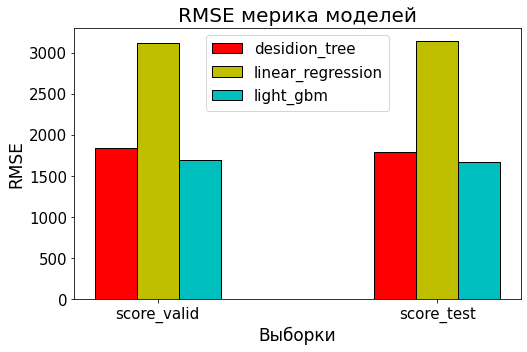

In [197]:
# устанавливаем некоторые параметры рисунка
plt.figure(figsize=[8, 5])
wd = 0.3
x_pos = np.arange(1, 2*len(df_score_table), 2)

# Рисуем столбчатую диаграму
plt.bar(x_pos, df_score_table['desidion_tree'], color='r', width=wd, edgecolor='k',
        label='desidion_tree')
plt.bar(x_pos+wd, df_score_table['linear_regression'], color='y', width=wd, edgecolor='k', 
        label='linear_regression')
plt.bar(x_pos+(wd*2), df_score_table['light_gbm'], color='c', width=wd, 
        edgecolor='k', label='light_gbm')

# Добавляем подписи
plt.xticks(x_pos+wd, df_score_table.index.values, fontsize=15)
plt.yticks(fontsize=15)
plt.title('RMSE мерика моделей', fontsize=20)
plt.xlabel('Выборки', fontsize=17)
plt.ylabel('RMSE', fontsize=17)

plt.legend(loc='upper center', fontsize=15)
plt.show()

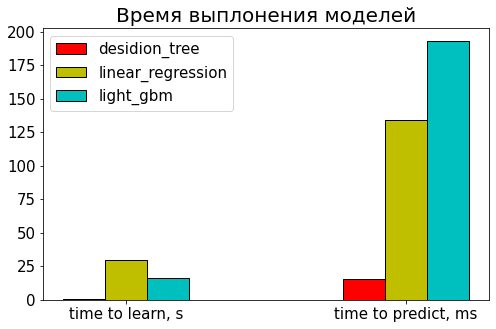

In [198]:
# устанавливаем некоторые параметры рисунка
plt.figure(figsize=[8, 5])
wd = 0.3
x_pos = np.arange(1, 2*len(df_score_table), 2)

# Рисуем столбчатую диаграму
plt.bar(x_pos, df_time_table['desidion_tree'], color='r', width=wd, edgecolor='k',
        label='desidion_tree')
plt.bar(x_pos+wd, df_time_table['linear_regression'], color='y', width=wd, edgecolor='k', 
        label='linear_regression')
plt.bar(x_pos+(wd*2), df_time_table['light_gbm'], color='c', width=wd, 
        edgecolor='k', label='light_gbm')

# Добавляем подписи
plt.xticks(x_pos+wd, df_time_table.index.values, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Время выплонения моделей', fontsize=20)

plt.legend(loc='upper left', fontsize=15)
plt.show()

**Вывод**

Для предсказания цены автомобиля были обучены и проанализированы несколько моделей машинного обучения:
- Решающее дерево
- Линейная регрессия
- Градиентный бустинг

Модели сравнивались по метрике RMSE и времени выполнения.

Наилучший результат показала модель решающего дерева.

    RMSE = 1795.7
    time to learn = 0.49 с
    time to predict = 15.7 мс
    
По метрике RMSE модель lightGBM показывает немного лучший результат (RMSE = 1670.7), однако модель сильно проигрывает по времени обучения и предсказания (16.5 с и 193 мс, соответсвенно)